# Perkenalan

Nama: Dwi Putra Satria Utama

Email: dwiputra3500@gmail.com

LinkedIn: https://www.linkedin.com/in/dwiputra3500/

Github: https://github.com/dwiputra35


`Objective:`

Tujuan dari proyek ini adalah untuk membangun model prediksi yang dapat mengidentifikasi apakah calon debitur memiliki risiko kredit berdasarkan berbagai fitur yang tersedia.

`Problem Statement:`

Dalam proyek ini, saya akan membangun sebuah model klasifikasi yang dapat memprediksi apakah calon debitur memiliki risiko kredit. Menggunakan dataset yang mencakup informasi hubungan antara fitur-fitur dengan status pinjaman debitur. Dengan demikian, model yang dihasilkan dapat digunakan untuk memberikan insight kepada institusi keuangan dalam mengidentifikasi risiko kredit yang lebih tinggi dan mengambil langkah-langkah pencegahan yang sesuai untuk mengelola risiko.


Pada kali ini kita akan fokus ke penilaian `recall` karena ingin memprediksi secara akurat `(true positive)` orang-orang yang berkemungkinan memiliki risiko kredit `(1)` dan penilaian `akurasi`.

# Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTENC

from sklearn.metrics import classification_report, confusion_matrix

from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
import time

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import pickle
import json

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# Prepare data

## Data dictionary

In [2]:
dict = pd.read_csv("data/LCDataDictionary.xlsx - LoanStats.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


## Import dataset

In [3]:
def categorize_loan(status):
    good_loan = ['Fully Paid', 'Current', 'In Grace Period',
                'Does not meet the credit policy. Status:Fully Paid']
    if status in good_loan:
        return 0
    else:
        return 1

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # drop kolom yang tidak digunakan
    kolom_yang_dihapus = ['Unnamed: 0', 'url', 'id', 'inq_last_12m', 'total_cu_tl',
                          'inq_fi', 'all_util', 'max_bal_bc',
                          'open_rv_24m', 'open_rv_12m', 'il_util', 'total_bal_il',
                          'mths_since_rcnt_il', 'open_il_24m', 'open_il_12m', 'open_il_6m',
                          'open_acc_6m', 'verification_status_joint', 'dti_joint', 'annual_inc_joint']

    df.drop(kolom_yang_dihapus, axis=1, inplace=True)

    # mengganti tipe data ke datetime dengan kita abaikan tahunnya karena fokus pada bulan dan tanggalnya
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%d', errors='coerce')
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%d', errors='coerce')
    df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'], format='%b-%d', errors='coerce')    
    df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%d', errors='coerce')

    # pada earliest cr line tidak kita abaikan tahunnya karena tahun pada kolom ini adalah reprentatif pada kolom ini sendiri
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y', errors='coerce')

    
    # ekstrak nilai numerik dari 'term' dan buat kolom baru 'term_months'
    df['term_months']=df['term'].str.replace(' months', '')
    df.drop('term', axis=1, inplace=True)

    # tambahkan kolom baru 'loan_category' berdasarkan kategori pinjaman
    df['loan_category'] = df['loan_status'].apply(categorize_loan)

    

    return df


Sebelum saya melakukan load data saya melakukan transformasi yang dibungkus dengan function. Beberapa transformasi diantaranya:


1. Menghapus beberapa kolom yang ditentukan dalam list kolom_yang_dihapus

2. Mengonversi kolom tanggal 

3. Mengambil nilai numerik dari kolom 'term', menghapus string ' months', dan membuat kolom baru 'term_months'. Kolom 'term' asli kemudian dihapus.

4. Mengkategori Pinjaman: Menambahkan kolom baru 'loan_category' 

Pengkategorian pinjaman dilakukan dengan referensi berikut:


1. **'Fully Paid'**: Ini adalah pinjaman yang telah dibayar penuh oleh peminjam. Ini adalah contoh pinjaman yang baik karena menunjukkan bahwa peminjam telah memenuhi kewajibannya.

2. **'Current'**: Ini adalah pinjaman di mana peminjam masih melakukan pembayaran tepat waktu. Ini adalah contoh pinjaman yang baik.

3. **'In Grace Period'**: Ini adalah periode waktu setelah jatuh tempo pembayaran di mana peminjam masih bisa melakukan pembayaran tanpa dikenakan denda. Jika pembayaran dilakukan dalam periode ini, pinjaman tersebut masih bisa dianggap baik.

4. **'Charged Off'**: Ini adalah pinjaman yang dianggap tidak akan dibayar oleh peminjam dan telah dihapus dari buku oleh pemberi pinjaman. Ini adalah contoh pinjaman yang buruk.

5. **'Default'**: Ini adalah pinjaman di mana peminjam telah gagal melakukan pembayaran untuk jangka waktu tertentu. Ini adalah contoh pinjaman yang buruk.

6. **'Late (31-120 days)'** dan **'Late (16-30 days)'**: Ini adalah pinjaman di mana peminjam terlambat melakukan pembayaran. Semakin lama keterlambatan, semakin buruk pinjaman tersebut.

7. **'Does not meet the credit policy. Status:Fully Paid'** dan **'Does not meet the credit policy. Status:Charged Off'**: Ini adalah pinjaman yang tidak memenuhi kebijakan kredit pemberi pinjaman. Status 'Fully Paid' berarti pinjaman telah dibayar penuh, sementara 'Charged Off' berarti pinjaman telah dihapus. Kedua kategori ini bisa dianggap baik atau buruk tergantung pada status pembayarannya.



Sumber: 

(1) Good Loan vs Bad Loan - How to Distinguish Between the Two - Wishfin. https://www.wishfin.com/articles/good-loan-vs-bad-loan/.

(2) Understanding Different Loan Types - Investopedia. https://www.investopedia.com/articles/pf/07/loan_types.asp.

(3) Good Debt vs. Bad Debt | Bankrate. https://www.bankrate.com/personal-finance/debt/good-debt-vs-bad-debt/.

(4) Good Debt vs. Bad Debt: Examples and Solutions - NerdWallet. https://www.nerdwallet.com/article/finance/good-debt-vs-bad-debt.

(5) id.wikipedia.org. https://id.wikipedia.org/wiki/Pinjaman.

In [4]:
df = wrangle('data/loan_data_2007_2014.csv')


C:\Users\DELL\AppData\Local\Temp\ipykernel_8252\2504999412.py:11: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [5]:
duplicate = df.duplicated().sum()
duplicate

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 56 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   member_id                    466285 non-null  int64         
 1   loan_amnt                    466285 non-null  int64         
 2   funded_amnt                  466285 non-null  int64         
 3   funded_amnt_inv              466285 non-null  float64       
 4   int_rate                     466285 non-null  float64       
 5   installment                  466285 non-null  float64       
 6   grade                        466285 non-null  object        
 7   sub_grade                    466285 non-null  object        
 8   emp_title                    438697 non-null  object        
 9   emp_length                   445277 non-null  object        
 10  home_ownership               466285 non-null  object        
 11  annual_inc                

# Exploratory data analysis

**Faktor-faktor apa yang paling berkontribusi terhadap ketidakmampuan bayar pinjaman?**

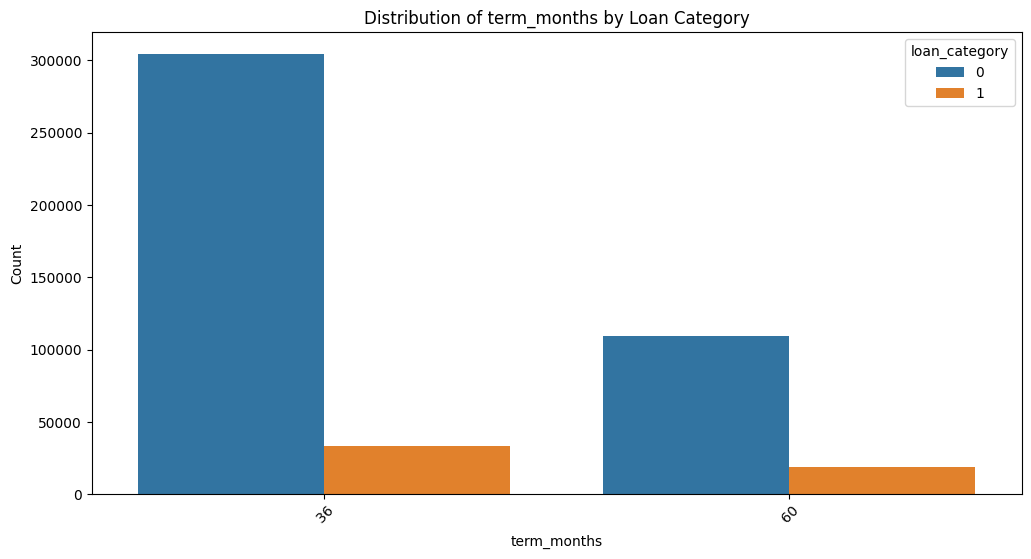

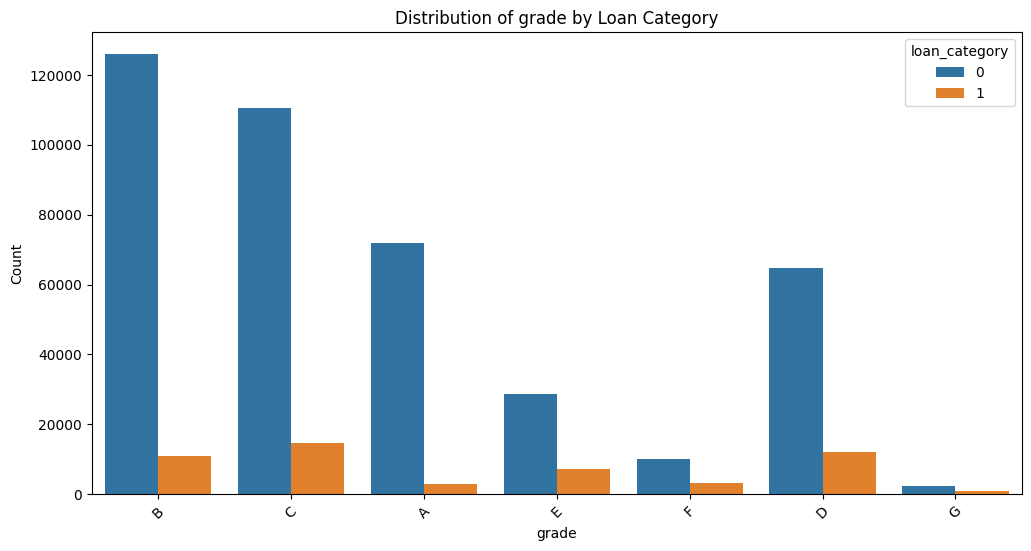

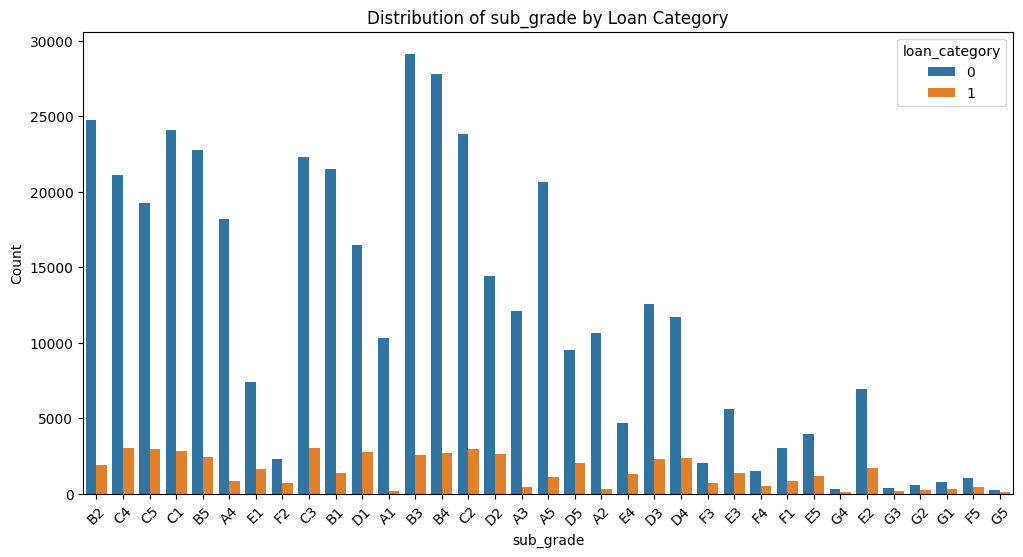

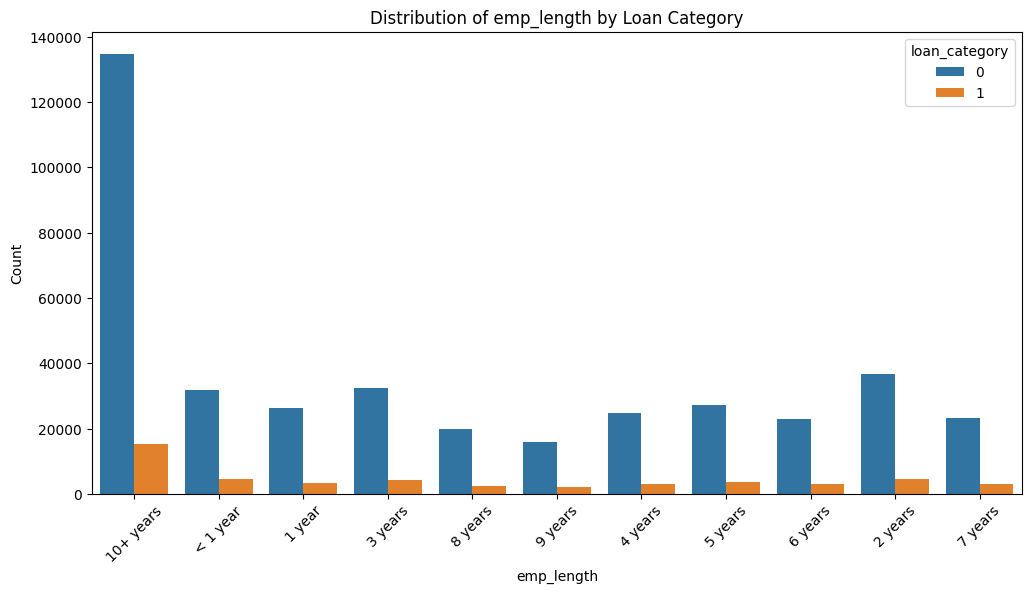

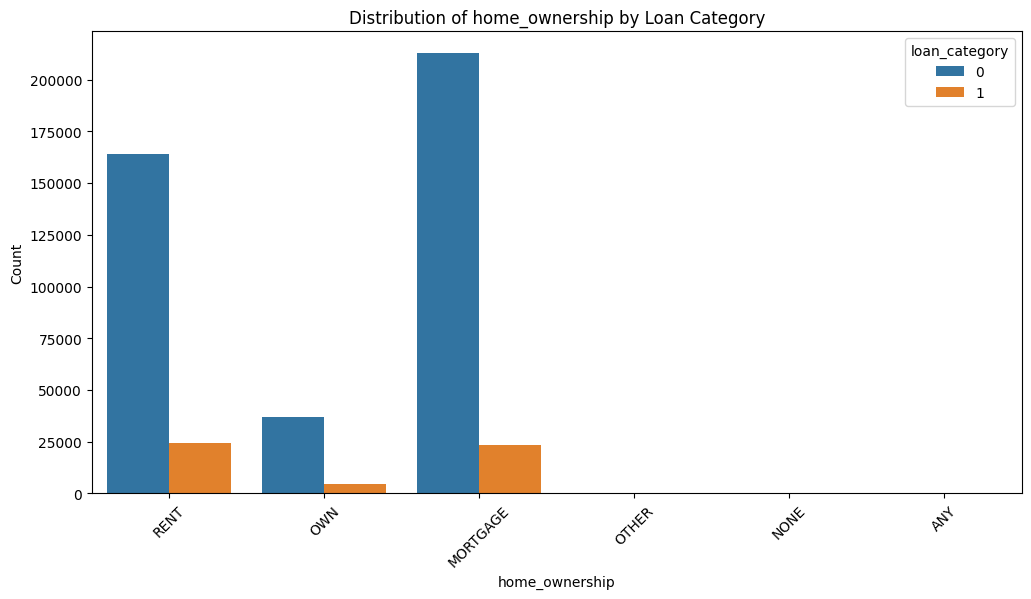

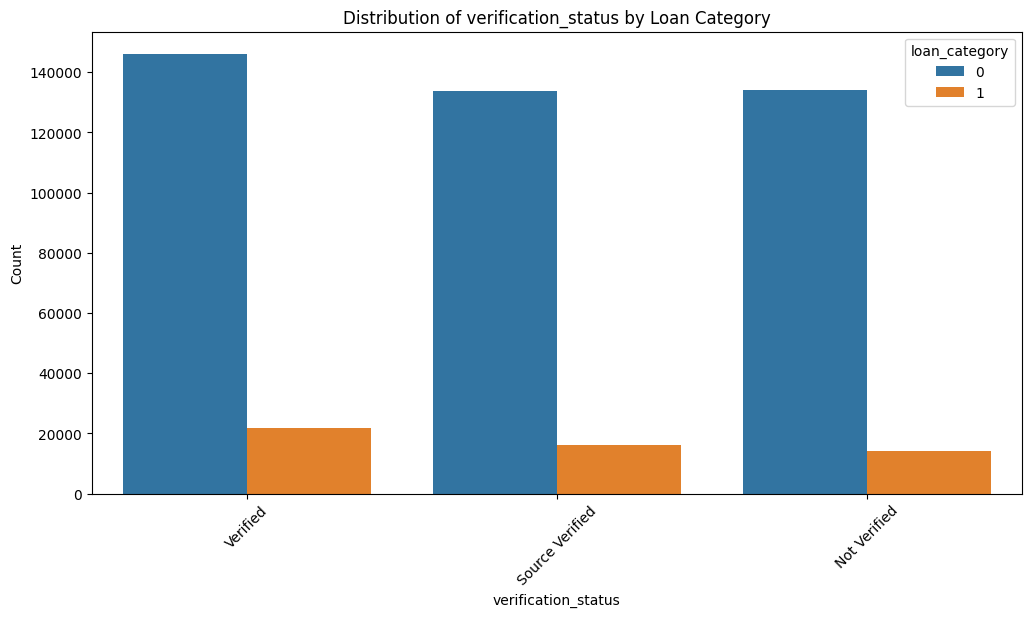

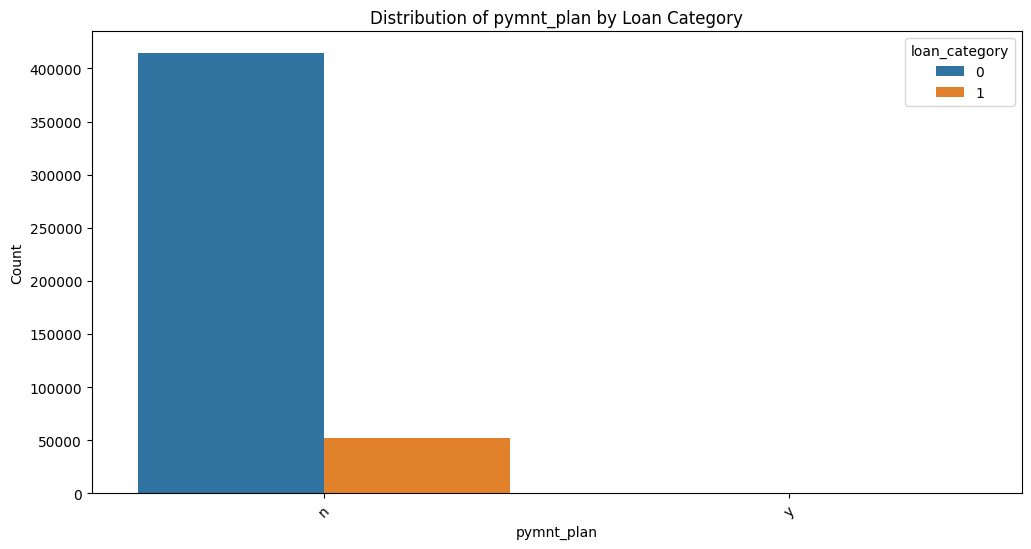

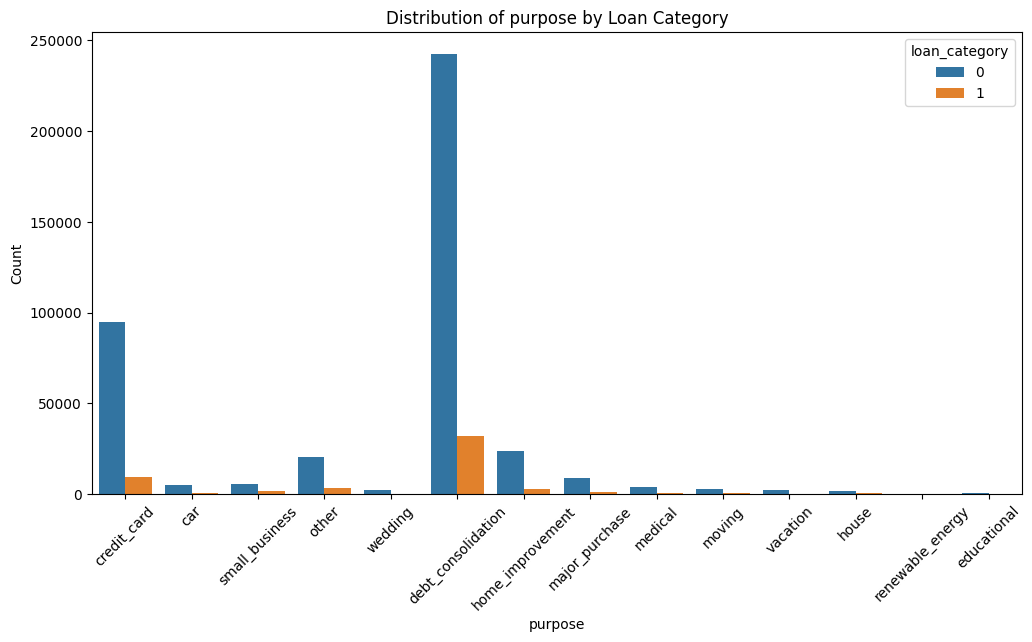

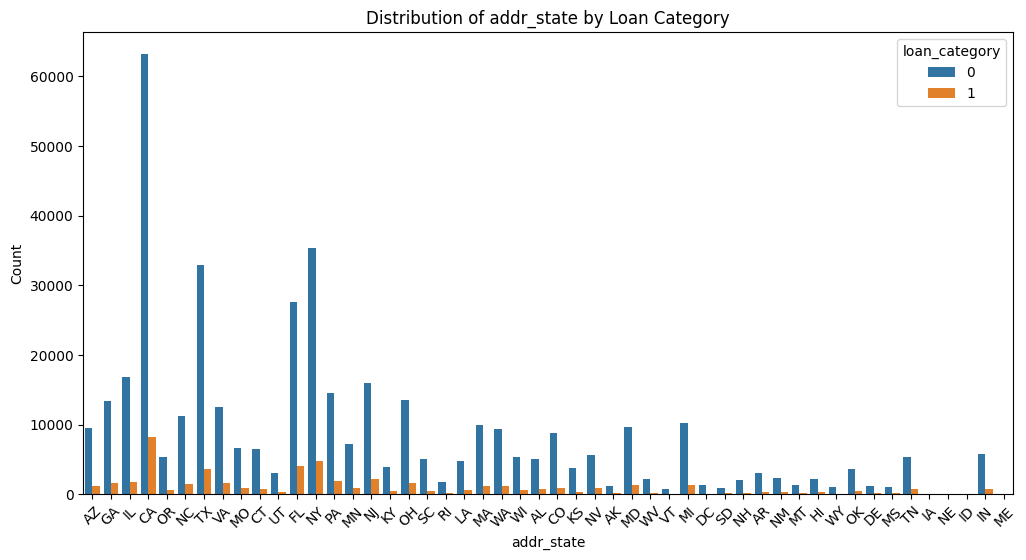

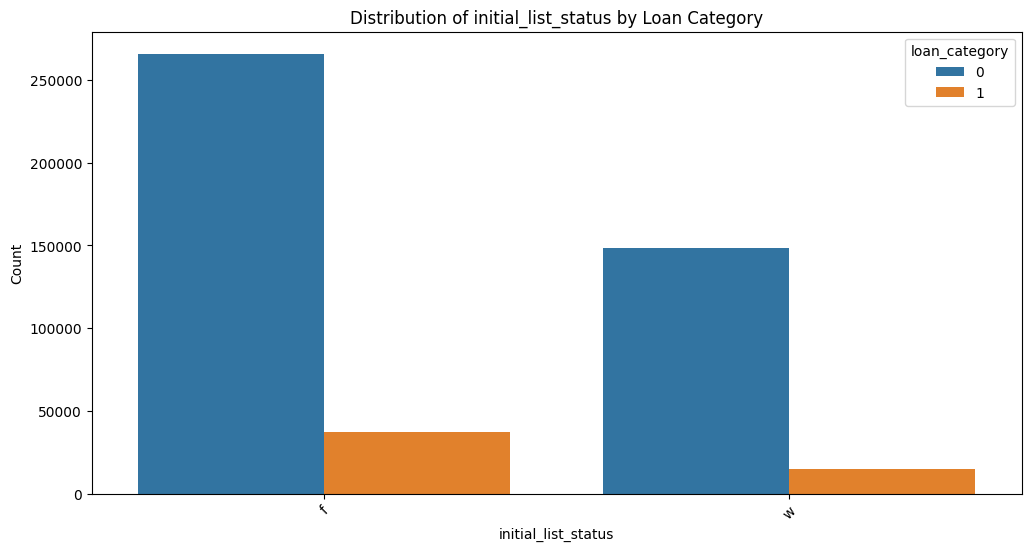

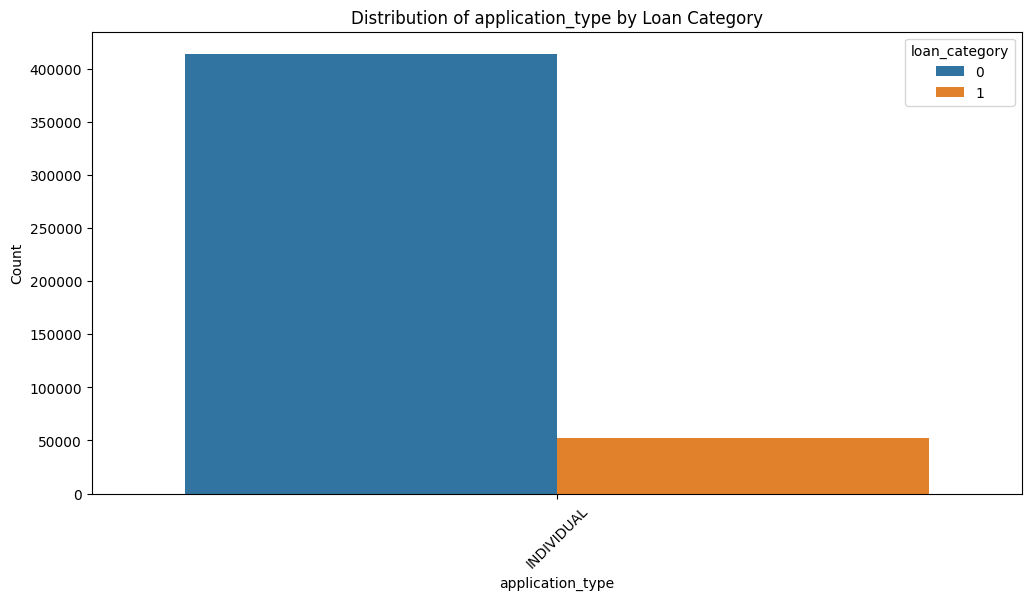

In [7]:
# Explore categorical variables with rotated x-axis labels
categorical_columns = ['term_months','grade','sub_grade','emp_length',
                       'home_ownership', 'verification_status', 'pymnt_plan',
                       'purpose', 'addr_state', 'initial_list_status',
                       'application_type']

for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=column, data=df, hue='loan_category')
    plt.title(f'Distribution of {column} by Loan Category')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45) 
    plt.show()

Dari visualisasi yang ada, dapat disimpulkan bahwa debitur yang memiliki bad loan adalah debitur yang termnya 36 bulan, durasi kerjanya lebih dari 10 tahun, kepemilikan rumahnya rent dan mortgage, purposenya untuk debt consolidation, statenya berada di CA.

**Analisis Kelompok Berisiko Tinggi**

In [47]:
non_risk = df[df['loan_status'].isin(['Fully Paid', 'Current'])]
non_risk.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
member_id,408965,15023977,70699,4848490,12326727,23493526,40860827,11743058
loan_amnt,408965,14291,500,8000,12000,20000,35000,8269
funded_amnt,408965,14268,500,8000,12000,20000,35000,8258
funded_amnt_inv,408965,14220,0,8000,12000,19950,35000,8269
int_rate,408965,14,5,10,13,16,26,4
installment,408965,431,16,255,378,565,1410,243
annual_inc,408965,74255,3000,45000,64000,90000,7500000,56332
issue_d,408965,1900-07-17 12:46:57.958504448,1900-01-08 00:00:00,1900-04-14 00:00:00,1900-07-14 00:00:00,1900-10-14 00:00:00,1900-12-14 00:00:00,NaN
dti,408965,17,0,11,17,23,40,8
delinq_2yrs,408965,0,0,0,0,0,29,1


In [48]:
high_risk = df[df['loan_status'].isin(['Charged Off', 'Default'])]
high_risk.describe().transpose()


,count,mean,min,25%,50%,75%,max,std
member_id,43307,10279642,80353,1784816,7432069,14907630,40603904,9846251
loan_amnt,43307,14533,900,8000,12600,20000,35000,8373
funded_amnt,43307,14486,900,8000,12550,20000,35000,8345
funded_amnt_inv,43307,14360,0,8000,12300,19950,35000,8371
int_rate,43307,16,5,13,16,19,26,4
installment,43307,440,22,265,391,573,1408,246
annual_inc,43307,64767,4080,40000,56000,78000,932000,39957
issue_d,43307,1900-07-05 06:16:53.988500736,1900-01-08 00:00:00,1900-04-13 00:00:00,1900-07-13 00:00:00,1900-10-12 00:00:00,1900-12-14 00:00:00,NaN
dti,43307,18,0,12,18,24,40,8
delinq_2yrs,43307,0,0,0,0,0,18,1


- annual_inc
	 
    Insight:

    Debitur pada kategori "non-risk" memiliki rata-rata pendapatan yang lebih tinggi ($74,255) dibandingkan dengan debitur pada kategori "high risk" ($64,767).
    Deviasi standar yang tinggi pada kedua kategori menunjukkan variasi yang cukup besar dalam pendapatan.

    
    Rekomendasi Bisnis:

    - Mungkin diperlukan peninjauan ulang terhadap kebijakan peminjaman untuk kategori "high risk" guna meminimalkan risiko gagal bayar.
    - Fokus pada pengembangan produk atau layanan yang lebih sesuai dengan profil dan kemampuan pembayaran debitur pada kategori "high risk".
    - Perlu dilakukan analisis lebih lanjut untuk memahami faktor-faktor lain yang dapat memberikan wawasan tambahan terkait risiko kredit.

- dti

    Insight:

    - Debitur pada kategori "non-risk" memiliki rata-rata Debt-to-Income (DTI) yang lebih rendah (17) dibandingkan dengan debitur pada kategori "high risk" (18).
    - Meskipun rata-rata DTI berbeda, deviasi standar yang sama pada kedua kategori menunjukkan bahwa ada variasi yang cukup besar dalam DTI di setiap kategori.

    Rekomendasi Bisnis:

    - Pertimbangkan untuk menetapkan batasan DTI yang lebih ketat untuk kategori "high risk" guna meminimalkan risiko gagal bayar.
    - Melakukan pendekatan risiko khusus terhadap debitur pada kategori "high risk" dengan penilaian lebih cermat terhadap kemampuan mereka untuk melunasi pinjaman.
    - Lakukan pemantauan berkala terhadap debitur pada kedua kategori untuk mengidentifikasi perubahan dalam kondisi keuangan mereka.



- revol_util

    Insight:
    
    - Penggunaan total kredit (revolving credit utilization) pada kategori "high risk" (60%) lebih tinggi dibandingkan dengan kategori "non-risk" (56%).
    - Tingkat penggunaan kredit yang tinggi dapat mengindikasikan tekanan keuangan pada debitur.
    
    Rekomendasi Bisnis:
    
    - Perlu dipertimbangkan pendekatan khusus dalam menilai risiko berdasarkan tingkat penggunaan kredit pada kategori "high risk".
    - Edukasi dan dukungan tambahan bagi debitur pada kategori "high risk" untuk manajemen keuangan yang lebih baik.
    Implementasi strategi mitigasi risiko yang spesifik untuk mengatasi tingkat penggunaan kredit yang tinggi.


# Feature selection

Dalam membuat model yang dapat mengurangi resiko kredit pada lending company, maka asumsinya adalah melakukan pencegahan awal kepada profile high risk yang akan melakukan percobaan apply pinjaman. Sehingga orang orang yang pinjamannya dapat diterima adalah profile yang kemungkinan gagal bayarnya rendah. Jadi fokus fitur yang akan kita seleksi dalam pembuatan model ini adalah fitur input ketika orang akan mengajukan pinjaman.

Dalam mengurangi resiko kredit, kita juga dapat membuat filter (logic) yang mana jika  debitur memiliki historcal pembayaran yang buruk, maka jika debitur tersebut akan melakukan pinjaman kembali, pinjaman tersebut akan ditolak.

Atau membuat filter (logic) yang mana jika debitur masih memiliki pinjaman, tetapi mau melakukan pinjaman kembali. Bisa saja diterima, tetapi pinjaman baru harus melunasi hutang yang sebelumnya dahulu, kemudian sisanya baru dapat dicairkan ke debitur.

Tetapi fokus kali ini adalah melakukan pencegahan awal untuk melakukan seleksi kepada debitur yang akan melakukan pinjaman.

In [10]:

categorical_columns = ['term_months','grade','sub_grade','emp_length',
                       'emp_title', 'home_ownership', 'verification_status', 'pymnt_plan',
                       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status',
                       'application_type', 'loan_status']

# Cek korelasi fitur kategori dengan target
# Uji chi-square
for column in categorical_columns:
    crosstab = pd.crosstab(df[column], df['loan_category'])
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    
    print(f"Uji chi-square kolom {column}:")
    print(f"Chi-square: {chi2}")
    print(f"P-value: {p_value}")
    print("")

Uji chi-square kolom term_months:
Chi-square: 1948.071775244153
P-value: 0.0

Uji chi-square kolom grade:
Chi-square: 13173.15988014826
P-value: 0.0

Uji chi-square kolom sub_grade:
Chi-square: 13849.018344493757
P-value: 0.0

Uji chi-square kolom emp_length:
Chi-square: 206.9568374872602
P-value: 5.702044396560484e-39

Uji chi-square kolom emp_title:
Chi-square: 233590.1942838492
P-value: 0.0

Uji chi-square kolom home_ownership:
Chi-square: 974.1648028833481
P-value: 2.3545343371110562e-208

Uji chi-square kolom verification_status:
Chi-square: 987.6702109162195
P-value: 3.3895241256017346e-215

Uji chi-square kolom pymnt_plan:
Chi-square: 13.637698212782183
P-value: 0.00022168904663663605

Uji chi-square kolom desc:
Chi-square: 124581.44563150142
P-value: 0.3833169536190048

Uji chi-square kolom purpose:
Chi-square: 1895.8639201116162
P-value: 0.0

Uji chi-square kolom title:
Chi-square: 80417.08360571218
P-value: 0.0

Uji chi-square kolom zip_code:
Chi-square: 2031.1339660790932
P-

Variabel yang memiliki hubungan sangat kuat dapat diidentifikasi berdasarkan p-value yang sangat kecil. Dalam hal ini, variabel-variabel seperti term_months, grade, sub_grade, emp_length, emp_title, home_ownership, verification_status, purpose, title, zip_code, addr_state, dan initial_list_status memiliki p-value yang sangat kecil (kurang dari 0.05), sehingga menunjukkan hubungan yang signifikan.

In [11]:
# Kolom-kolom numerik (selain objek)
numeric_columns = df.select_dtypes(exclude=['object']).columns

# Filter kolom numerik yang tidak termasuk dalam kolom kategorikal yang sudah didefinisikan
numeric_columns = numeric_columns.difference(categorical_columns)

# Menghitung korelasi antara variabel numerik dengan variabel target
correlation_results = df[numeric_columns.union(['loan_category'])].corr()['loan_category'].drop('loan_category')

correlation_results.abs().sort_values(ascending=False)

recoveries                     0.435352
collection_recovery_fee        0.295281
total_rec_prncp                0.254255
next_pymnt_d                   0.231963
total_pymnt_inv                0.194638
total_pymnt                    0.193977
int_rate                       0.174648
last_pymnt_amnt                0.170164
total_rec_late_fee             0.151624
out_prncp                      0.150442
out_prncp_inv                  0.150430
member_id                      0.092375
inq_last_6mths                 0.073109
last_pymnt_d                   0.072062
revol_util                     0.051020
tot_cur_bal                    0.050865
annual_inc                     0.049484
dti                            0.049092
total_rev_hi_lim               0.037735
earliest_cr_line               0.031963
issue_d                        0.029222
total_rec_int                  0.022833
mths_since_last_record         0.022542
total_acc                      0.022366
revol_bal                      0.018536


Dalam interpretasi korelasi, biasanya nilai absolut dari korelasi digunakan untuk mengevaluasi kekuatan hubungan antar variabel. Umumnya, nilai korelasi antara 0.2 hingga 0.4 dianggap sebagai korelasi lemah, antara 0.4 hingga 0.7 dianggap sebagai korelasi cukup kuat, dan di atas 0.7 dianggap sebagai korelasi kuat. 

Tetapi dalam konteks ini saya akan menggunakan fitur-fitur yang tersedia pada saat pengajuan pinjaman seperti 'term_months', 'grade', 'sub_grade', 'emp_length', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'annual_inc', 'int_rate', 'dti', 'loan_status', 'annual_inc' , 'int_rate' dan 'dti'.

Kolom title dan zip_code tidak digunakan dengan alasan sudah representatif terhadap kolom purpose dan addr_state

## Memisihkan antara fitur `X` dan target `y`

In [12]:
df_filter = df[['term_months', 'grade', 'sub_grade', 'emp_length', 'emp_title', 'home_ownership',
                'verification_status', 'purpose', 'addr_state', 'initial_list_status',
                'annual_inc', 'int_rate', 'dti', 'loan_status', 'loan_category']]

In [13]:
df_filter.shape

(466285, 15)

## Handling missing values

In [14]:
df_filter.isnull().sum()

term_months                0
grade                      0
sub_grade                  0
emp_length             21008
emp_title              27588
home_ownership             0
verification_status        0
purpose                    0
addr_state                 0
initial_list_status        0
annual_inc                 4
int_rate                   0
dti                        0
loan_status                0
loan_category              0
dtype: int64

Terdapat missing value yang cukup banyak pada kolom emp_length dan emp_title. Untuk penangannya lanjutannya akan dilihat pola atau karakteristiknya terlebih dahulu

In [15]:
df_missing = df[df[['emp_length', 'emp_title']].isnull().any(axis=1)]

In [16]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

df_missing.annual_inc.describe()


count     27770
mean      59931
std       49514
min        2000
25%       32000
50%       49452
75%       71657
max     1440000
Name: annual_inc, dtype: float64

In [17]:
df_missing[['purpose','annual_inc', 'emp_length', 'emp_title' ]].head(20)

,purpose,annual_inc,emp_length,emp_title
0,credit_card,24000,10+ years,NaN
2,small_business,12252,10+ years,NaN
8,small_business,40000,4 years,NaN
30,debt_consolidation,17108,7 years,NaN
42,other,65000,9 years,NaN
61,small_business,40000,6 years,NaN
110,small_business,110000,8 years,NaN
168,debt_consolidation,12000,NaN,NaN
186,credit_card,74000,9 years,NaN
199,debt_consolidation,75000,6 years,NaN


In [18]:
df_missing[['purpose','annual_inc', 'emp_length', 'emp_title' ]].tail(20)

,purpose,annual_inc,emp_length,emp_title
466213,medical,50000,10+ years,NaN
466214,debt_consolidation,84000,10+ years,NaN
466215,credit_card,200000,10+ years,NaN
466216,debt_consolidation,32000,NaN,NaN
466224,debt_consolidation,150000,4 years,NaN
466233,debt_consolidation,47000,10+ years,NaN
466234,credit_card,50000,NaN,NaN
466235,credit_card,250000,10+ years,NaN
466236,debt_consolidation,108000,5 years,NaN
466244,debt_consolidation,66000,4 years,NaN


Berdasarkan pengecekan didapatkan bahwa data yang hilang masuk kedalam `MCAR (Missing Completely At Random)`, sehingga penanganan yang paling tepat adalah dengan melakukan penghapusan. Karena jika dilakukan imputasi, makan datanya akan bias sehingga akan mempengaruhi model

In [19]:
df_filter.dropna(inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_8252\3571784092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.dropna(inplace=True)


In [20]:
df_filter.shape

(438511, 15)

## Handling imbalance target

In [21]:
df_filter.loan_category.value_counts()

loan_category
0    390260
1     48251
Name: count, dtype: int64

Didapatkan bahwa data target adalah immbalance. Data imbalance dapat dihandling dengan undersampling atau oversampling menggunakan SMOTE jika fiturnya full numerik atau SMOTENC jika fiturnya kombinasi antara numerik dan kategori.

Tetapi kali ini saya akan melakukan undersampling pada kedua kelas dengan alasan: 

1. Melakukan balancing data target

2. komputasi, dikarenakan keterbatasan spesifikasi device penunjang

In [22]:
# Mengambil sampel dari kategori "good"
undersampled_good = df_filter[df_filter['loan_category'] == 0].sample(n=48251, random_state=42)
undersampled_bad = df_filter[df_filter['loan_category'] == 1].sample(n=48251, random_state=42)

# Menggabungkan hasil undersampling dengan kategori "bad"
df_under = pd.concat([undersampled_good, undersampled_bad])


## Memisahkan antara fitur dan target


In [23]:
# splitting X dan y
X = df_under[['term_months', 'grade', 'sub_grade', 'emp_length', 'emp_title', 'home_ownership',
                'verification_status', 'purpose', 'addr_state', 'initial_list_status',
                'annual_inc', 'int_rate', 'dti', 'loan_status']]

y = df_under['loan_category']

## Memisahkan antara train set dan test set


In [24]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)

Train Size :  (77201, 14)
Test Size :  (19301, 14)


## Handling outliers

Skipping non-numeric column: term_months
Skipping non-numeric column: grade
Skipping non-numeric column: sub_grade
Skipping non-numeric column: emp_length
Skipping non-numeric column: emp_title
Skipping non-numeric column: home_ownership
Skipping non-numeric column: verification_status
Skipping non-numeric column: purpose
Skipping non-numeric column: addr_state
Skipping non-numeric column: initial_list_status


<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

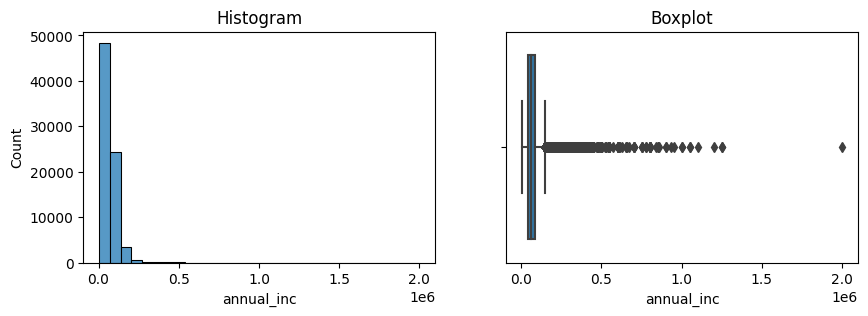

Skewness: 5.9839393769785705
The distribution is skewed


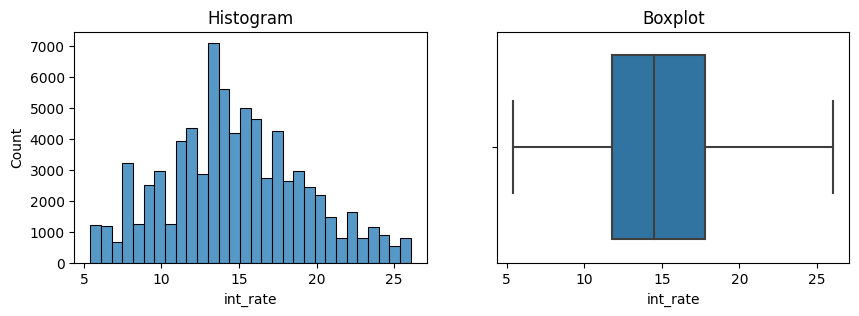

Skewness: 0.21901809761058375
The distribution is normal


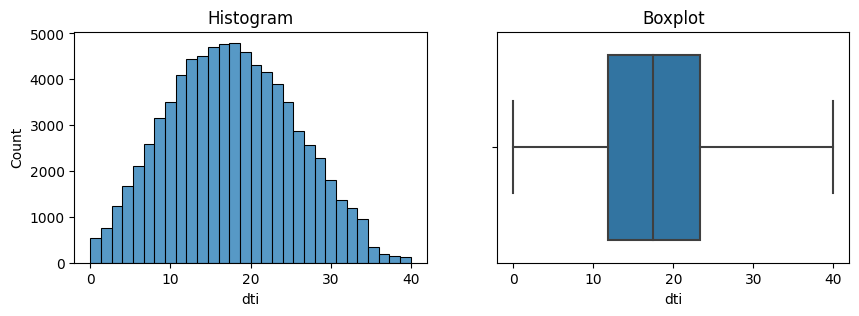

Skewness: 0.1261838378035867
The distribution is normal
Skipping non-numeric column: loan_status
Skipping non-numeric column: term_months
Skipping non-numeric column: grade
Skipping non-numeric column: sub_grade
Skipping non-numeric column: emp_length
Skipping non-numeric column: emp_title
Skipping non-numeric column: home_ownership
Skipping non-numeric column: verification_status
Skipping non-numeric column: purpose
Skipping non-numeric column: addr_state
Skipping non-numeric column: initial_list_status


<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

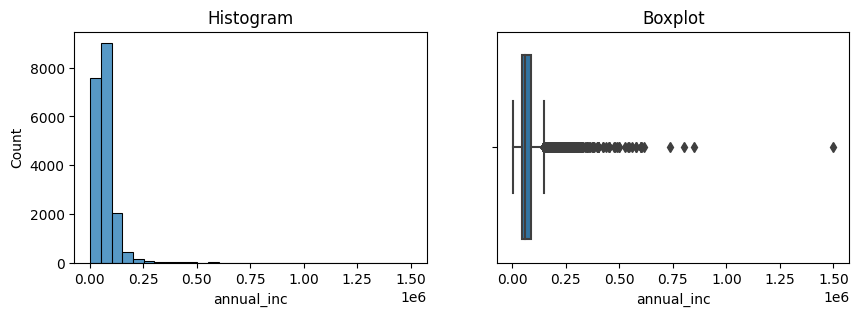

Skewness: 5.317463798586986
The distribution is skewed


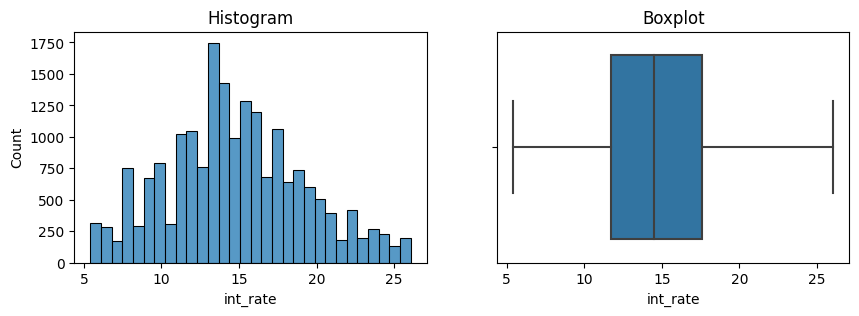

Skewness: 0.22889249593528424
The distribution is normal


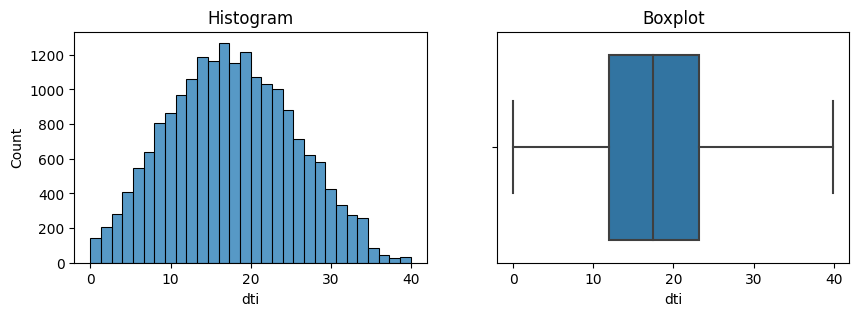

Skewness: 0.1174552358785151
The distribution is normal
Skipping non-numeric column: loan_status


<Figure size 1000x300 with 0 Axes>

In [25]:
def check_distribution_outliers(X, columns):
    for column in columns:
        plt.figure(figsize=(10, 3))

        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(X[column]):
            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(X[column], bins=30)
            plt.title('Histogram')

            # Boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=X[column])
            plt.title('Boxplot')

            plt.show()

            print('Skewness:', X[column].skew())
            if (X[column].skew() <= -0.5) or (X[column].skew() >= 0.5):
                print('The distribution is skewed')
            else:
                print('The distribution is normal')
        else:
            print(f"Skipping non-numeric column: {column}")

# 
check_distribution_outliers(X_train, X_train.columns)

# 
check_distribution_outliers(X_test, X_test.columns)


Berdasarkan hasil tersebut terdapat outlier, sehingga akan dilakukan penanganan dengan metode  IQR Winsorization dengan alasan metode ini lebih mempertahankan distribusi asli dari data daripada metode yang menghapus outlier sepenuhnya, sehingga tidak merubah struktur dasar data.

Penanganan outlier juga dilakukan karena alasan penggunan model logistic regression yang tidak tahan outlier.

In [26]:
def iqr_winsorize_column(X, column):
    q1 = X[column].quantile(0.25)
    q3 = X[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    winsorized = X[column].clip(lower_bound, upper_bound)
    X[column] = winsorized
    return X

# Penanganan outlier dengan IQR winsorization pada X_train
for feature in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[feature]):
        X_train = iqr_winsorize_column(X_train, feature)

# Penanganan outlier dengan IQR winsorization pada X_test
for feature in X_test.columns:
    if pd.api.types.is_numeric_dtype(X_test[feature]):
        X_test = iqr_winsorize_column(X_test, feature)


In [27]:
print(X_train.shape)
print(y_train.shape)

(77201, 14)
(77201,)


# Feature scaling & Feature encoding

In [28]:
X_train.head()

,term_months,grade,sub_grade,emp_length,emp_title,home_ownership,verification_status,purpose,addr_state,initial_list_status,annual_inc,int_rate,dti,loan_status
116510,60,C,C4,3 years,Westconsin Credit Union,MORTGAGE,Verified,debt_consolidation,WI,f,80000,16,21,Current
454872,36,B,B3,6 years,General Manager,MORTGAGE,Verified,debt_consolidation,NC,f,90000,12,18,Current
320696,60,D,D3,8 years,procurement,RENT,Verified,home_improvement,NY,w,45000,17,16,Charged Off
81085,36,A,A3,2 years,ARNP,MORTGAGE,Verified,debt_consolidation,KY,f,108000,8,16,Fully Paid
158445,36,D,D1,8 years,American mattress,MORTGAGE,Verified,other,IL,f,46000,18,18,Charged Off


In [29]:
X.columns

Index(['term_months', 'grade', 'sub_grade', 'emp_length', 'emp_title',
       'home_ownership', 'verification_status', 'purpose', 'addr_state',
       'initial_list_status', 'annual_inc', 'int_rate', 'dti', 'loan_status'],
      dtype='object')

In [30]:


# Define your ordinal, numerical, and categorical columns
ordinal_columns = ['grade', 'sub_grade']

numerical_columns = ['annual_inc', 'int_rate', 'dti']

categorical_columns = ['term_months', 'grade', 'sub_grade', 'emp_length', 'emp_title',
       'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'loan_status']

# Define ordinal encoders
grade_encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
subgrade_encoder = OrdinalEncoder(categories=[['A1', 'A2', 'A3', 'A4', 'A5',
                                                'B1', 'B2', 'B3', 'B4', 'B5',
                                                'C1', 'C2', 'C3', 'C4', 'C5',
                                                'D1', 'D2', 'D3', 'D4', 'D5',
                                                'E1', 'E2', 'E3', 'E4', 'E5',
                                                'F1', 'F2', 'F3', 'F4', 'F5',
                                                'G1', 'G2', 'G3', 'G4', 'G5']])


# Define transformers for each data type
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = ColumnTransformer(
    transformers=[
        ('grade', grade_encoder, ['grade']),
        ('subgrade', subgrade_encoder, ['sub_grade']),
    ])

# smotenc = SMOTENC([1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], # lokasi fitur kategori
#                   sampling_strategy='minority',
#                   k_neighbors=4,
#                   random_state=42)


# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('ord', ordinal_transformer, ordinal_columns)
    ])

In [31]:
# logreg pipeline
model_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('smotenc', smotenc),
    ('classifier', LogisticRegression(random_state=20))
])

# model training
model_logreg.fit(X_train, y_train)

# model predict
y_pred_train_logreg = model_logreg.predict(X_train)
y_pred_test_logreg = model_logreg.predict(X_test)
y_pred_train_logreg

# confusion matrix train 
print('Hasil prediksi train-set')
print(confusion_matrix(y_train, y_pred_train_logreg))

# confusion matrix test
print('\n Hasil prediksi test-set')
print(confusion_matrix(y_test, y_pred_test_logreg))

# classification report train 
print('Hasil prediksi train-set')
print(classification_report(y_train, y_pred_train_logreg))

# Classification report test
print('\n Hasil prediksi test-set')
print(classification_report(y_test, y_pred_test_logreg))

c:\Users\DELL\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hasil prediksi train-set
[[38634     0]
 [    0 38567]]

 Hasil prediksi test-set
[[9617    0]
 [   0 9684]]
Hasil prediksi train-set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38634
           1       1.00      1.00      1.00     38567

    accuracy                           1.00     77201
   macro avg       1.00      1.00      1.00     77201
weighted avg       1.00      1.00      1.00     77201


 Hasil prediksi test-set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9617
           1       1.00      1.00      1.00      9684

    accuracy                           1.00     19301
   macro avg       1.00      1.00      1.00     19301
weighted avg       1.00      1.00      1.00     19301



In [32]:
# Create the pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('smotenc', smotenc),
    ('classifier', DecisionTreeClassifier(random_state=20))
])

# Training pipeline with training data
dt_pipeline.fit(X_train, y_train)

# model predict
y_pred_train_dt = dt_pipeline.predict(X_train)
y_pred_test_dt = dt_pipeline.predict(X_test)
y_pred_train_dt


# classification report train 
print('Hasil prediksi train-set')
print(classification_report(y_train, y_pred_train_dt))

# Classification report test
print('\n Hasil prediksi test-set')
print(classification_report(y_test, y_pred_test_dt))

# confusion matrix train 
print('Hasil prediksi train-set')
print(confusion_matrix(y_train, y_pred_train_dt))

# confusion matrix test
print('\n Hasil prediksi test-set')
print(confusion_matrix(y_test, y_pred_test_dt))

Hasil prediksi train-set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38634
           1       1.00      1.00      1.00     38567

    accuracy                           1.00     77201
   macro avg       1.00      1.00      1.00     77201
weighted avg       1.00      1.00      1.00     77201


 Hasil prediksi test-set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9617
           1       1.00      1.00      1.00      9684

    accuracy                           1.00     19301
   macro avg       1.00      1.00      1.00     19301
weighted avg       1.00      1.00      1.00     19301

Hasil prediksi train-set
[[38634     0]
 [    0 38567]]

 Hasil prediksi test-set
[[9617    0]
 [   0 9684]]


# Neural Network with Keras (Sequential)

In [33]:
# Splitting between Train-Set, Val-Set, and Test-Set

X_train_val, X_test_dl, y_train_val, y_test_dl = train_test_split(X, y, test_size=0.15, random_state=20)
X_train_dl, X_val, y_train_dl, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=20)

print('Train Size : ', X_train_dl.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test_dl.shape)

Train Size :  (69722, 14)
Val Size :  (12304, 14)
Test Size :  (14476, 14)


Skipping non-numeric column: term_months
Skipping non-numeric column: grade
Skipping non-numeric column: sub_grade
Skipping non-numeric column: emp_length
Skipping non-numeric column: emp_title
Skipping non-numeric column: home_ownership
Skipping non-numeric column: verification_status
Skipping non-numeric column: purpose
Skipping non-numeric column: addr_state
Skipping non-numeric column: initial_list_status


<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

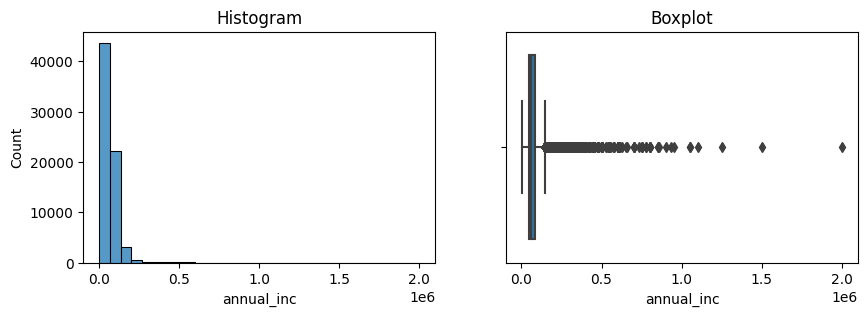

Skewness: 6.031090512520499
The distribution is skewed


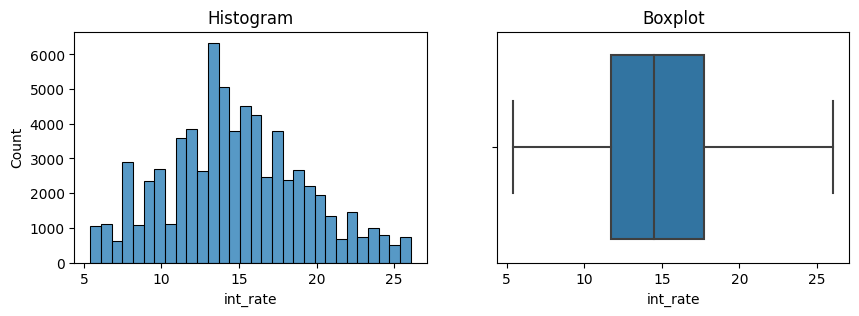

Skewness: 0.22242554250903154
The distribution is normal


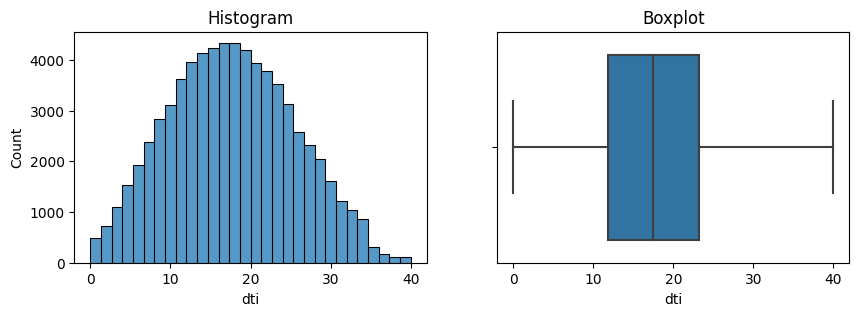

Skewness: 0.12053149987979057
The distribution is normal
Skipping non-numeric column: loan_status
Skipping non-numeric column: term_months
Skipping non-numeric column: grade
Skipping non-numeric column: sub_grade
Skipping non-numeric column: emp_length
Skipping non-numeric column: emp_title
Skipping non-numeric column: home_ownership
Skipping non-numeric column: verification_status
Skipping non-numeric column: purpose
Skipping non-numeric column: addr_state
Skipping non-numeric column: initial_list_status


<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

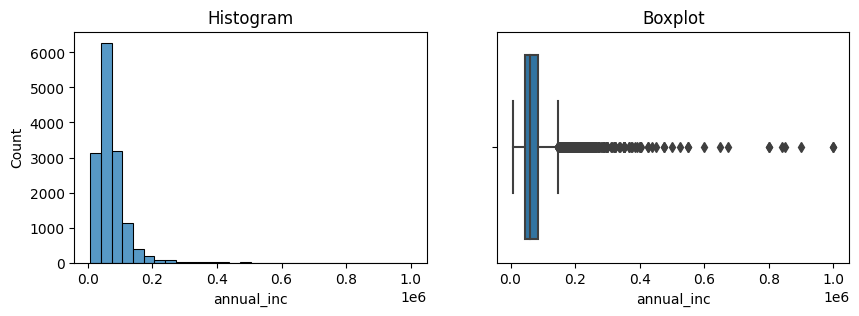

Skewness: 5.221975431180369
The distribution is skewed


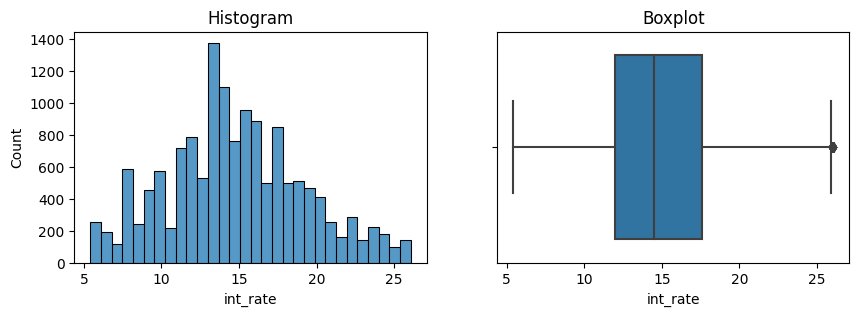

Skewness: 0.21357338589709082
The distribution is normal


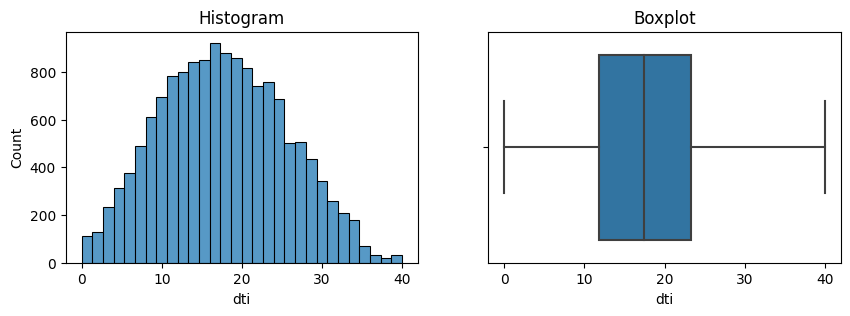

Skewness: 0.13175095833067774
The distribution is normal
Skipping non-numeric column: loan_status


<Figure size 1000x300 with 0 Axes>

In [34]:
def check_distribution_outliers(X, columns):
    for column in columns:
        plt.figure(figsize=(10, 3))

        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(X[column]):
            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(X[column], bins=30)
            plt.title('Histogram')

            # Boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=X[column])
            plt.title('Boxplot')

            plt.show()

            print('Skewness:', X[column].skew())
            if (X[column].skew() <= -0.5) or (X[column].skew() >= 0.5):
                print('The distribution is skewed')
            else:
                print('The distribution is normal')
        else:
            print(f"Skipping non-numeric column: {column}")

#
check_distribution_outliers(X_train_dl, X_train_dl.columns)

#
check_distribution_outliers(X_test_dl, X_test_dl.columns)


In [35]:
def iqr_winsorize_column(X, column):
    q1 = X[column].quantile(0.25)
    q3 = X[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    winsorized = X[column].clip(lower_bound, upper_bound)
    X[column] = winsorized
    return X

# Penanganan outlier dengan IQR winsorization pada X_train
for feature in X_train_dl.columns:
    if pd.api.types.is_numeric_dtype(X_train_dl[feature]):
        X_train_dl = iqr_winsorize_column(X_train_dl, feature)

# Penanganan outlier dengan IQR winsorization pada X_test
for feature in X_test_dl.columns:
    if pd.api.types.is_numeric_dtype(X_test_dl[feature]):
        X_test_dl = iqr_winsorize_column(X_test_dl, feature)


In [36]:
# Define your ordinal, numerical, and categorical columns
ordinal_columns = ['grade', 'sub_grade']

numerical_columns = ['annual_inc', 'int_rate', 'dti']

categorical_columns = ['term_months', 'grade', 'sub_grade', 'emp_length', 'emp_title',
       'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'loan_status']

# Define ordinal encoders
grade_encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
subgrade_encoder = OrdinalEncoder(categories=[['A1', 'A2', 'A3', 'A4', 'A5',
                                                'B1', 'B2', 'B3', 'B4', 'B5',
                                                'C1', 'C2', 'C3', 'C4', 'C5',
                                                'D1', 'D2', 'D3', 'D4', 'D5',
                                                'E1', 'E2', 'E3', 'E4', 'E5',
                                                'F1', 'F2', 'F3', 'F4', 'F5',
                                                'G1', 'G2', 'G3', 'G4', 'G5']])


# Define transformers for each data type
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = ColumnTransformer(
    transformers=[
        ('grade', grade_encoder, ['grade']),
        ('subgrade', subgrade_encoder, ['sub_grade']),
    ])

# smotenc = SMOTENC([1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], # lokasi fitur kategori
#                   sampling_strategy='minority',
#                   k_neighbors=4,
#                   random_state=42)


# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('ord', ordinal_transformer, ordinal_columns)
    ])

In [37]:
# Fit and Transform

X_train_dl = preprocessor.fit_transform(X_train_dl)
X_val = preprocessor.transform(X_val)
X_test_dl = preprocessor.transform(X_test_dl)
X_test_dl.shape

(14476, 44029)

In [38]:

# Assuming X_train, X_val, and X_test are your sparse matrices
X_train_sparse = tf.sparse.SparseTensor(indices=np.column_stack(X_train_dl.nonzero()), values=X_train_dl.data, dense_shape=X_train_dl.shape)
X_val_sparse = tf.sparse.SparseTensor(indices=np.column_stack(X_val.nonzero()), values=X_val.data, dense_shape=X_val.shape)
X_test_sparse = tf.sparse.SparseTensor(indices=np.column_stack(X_test_dl.nonzero()), values=X_test_dl.data, dense_shape=X_test_dl.shape)

# Tensorflow pipeline
batch_size = 20

train_pipe = tf.data.Dataset.from_tensor_slices((X_train_sparse, y_train_dl)).batch(batch_size)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val_sparse, y_val)).batch(batch_size)

## Sequential API

In [39]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [40]:
# Create Sequential API
model_sequential = Sequential([
    Dense(30, activation='selu', kernel_initializer=tf.keras.initializers.HeNormal(seed), input_shape=(44029,), kernel_regularizer=l2(0.001)), # Hidden layer 1 dengan L2 regularization
    Dropout(0.2),  # Adding Dropout
    Dense(24, activation='selu', kernel_initializer=tf.keras.initializers.HeNormal(seed), kernel_regularizer=l2(0.001)), # Hidden layer 2 dengan L2 regularization
    Dropout(0.2),  # Adding Dropout
    Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)) # Output Layer
])

# Compile dengan RMSprop optimizer
model_sequential.compile(loss='binary_crossentropy',
                         optimizer=RMSprop(learning_rate=0.001),
                         metrics=['accuracy'])

# Summary
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1320900   
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                744       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,321,669
Trainable params: 1,321,669
Non-trainable params: 0
_________________________________________________________________


- Activation Function Selu: Aktivasi Selu dipilih karena memiliki keuntungan dalam mencegah vanishing/exploding gradient dan dapat mempercepat konvergensi pada deep neural network.
- Kernel Initializer HeNormal: HeNormal digunakan karena cocok untuk aktivasi Selu dan Relu, mengurangi risiko vanishing/exploding gradient saat inisialisasi bobot.
- Input Shape: Sesuai dengan jumlah fitur pada data input
- L2 Regularization: Digunakan untuk mencegah overfitting dengan menambahkan regularisasi L2 pada bobot layer, dengan parameter 0.001 untuk mengontrol kekuatan regularisasi.
- Dropout: Digunakan untuk mencegah overfitting dengan mengatur tingkat dropout 0.2, yang berarti 20% neuron akan di-dropout secara acak setiap kali proses pelatihan.
- Sigmoid Activation Function: Digunakan pada output layer untuk mendapatkan probabilitas output yang berkisar antara 0 hingga 1, sesuai dengan klasifikasi biner.
- RMSprop Optimizer: Digunakan dengan learning rate 0.001 untuk mengoptimalkan proses pembelajaran model dengan mengurangi risiko ketidakstabilan dan kecepatan konvergensi yang lebih baik.

In [41]:
# Mendefinisikan EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Training model menggunakan train_pipe 
history_seq = model_sequential.fit(train_pipe,
                                   epochs=10,
                                   batch_size=70,
                                   validation_data=val_pipe,
                                   callbacks=[early_stopping])

Epoch 1/10


3487/3487 [==============================] - 71s 20ms/step - loss: 0.0214 - accuracy: 0.9968 - val_loss: 0.0042 - val_accuracy: 0.9998
Epoch 2/10
3487/3487 [==============================] - 70s 20ms/step - loss: 0.0052 - accuracy: 0.9993 - val_loss: 0.0037 - val_accuracy: 0.9999
Epoch 3/10
3487/3487 [==============================] - 70s 20ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9999
Epoch 4/10
3487/3487 [==============================] - 70s 20ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 0.0040 - val_accuracy: 0.9998
Epoch 5/10
3487/3487 [==============================] - 72s 21ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.0026 - val_accuracy: 0.9999


In [42]:
# Create DataFrame

history_seq_df = pd.DataFrame(history_seq.history)
history_seq_df

,loss,accuracy,val_loss,val_accuracy
0,0,1,0,1
1,0,1,0,1
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1


<Axes: >

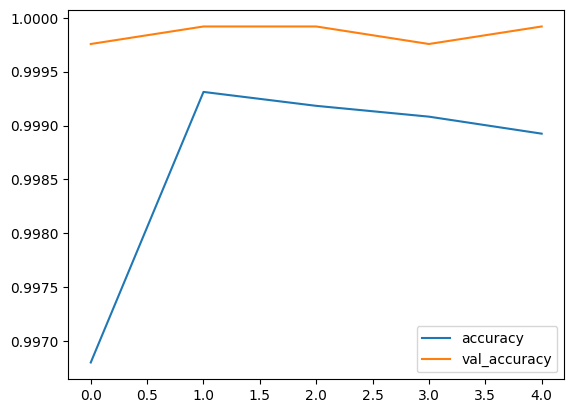

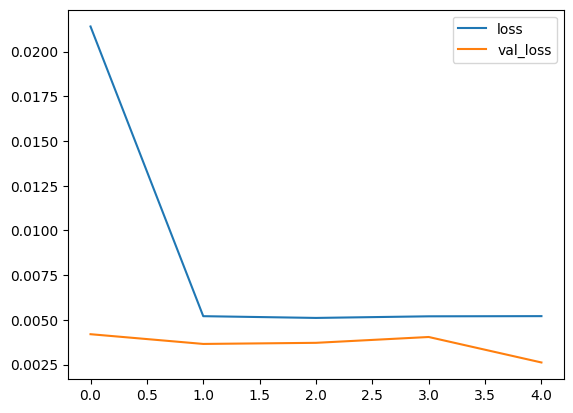

In [43]:
# Plot

history_seq_df[['accuracy', 'val_accuracy']].plot()
history_seq_df[['loss', 'val_loss']].plot()

In [44]:
# Model evaluation test set

y_pred_seq = model_sequential.predict(X_test_dl)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print(classification_report(y_test_dl, y_pred_seq))

453/453 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7179
           1       1.00      1.00      1.00      7297

    accuracy                           1.00     14476
   macro avg       1.00      1.00      1.00     14476
weighted avg       1.00      1.00      1.00     14476



Baik model logistic regression, decision tree, dan deep learning menggunakan sequential. Ketiganya memiliki performa yang sama sama bagus. Tetapi proses komputasi terbaik ada di model decision tree. Sehingga saya memilih decision tree sebagai model terbaik yang akan saya save untuk digunakan ditahap deployment.

# Save Model

In [45]:
# Save the Files


with open('list_num_cols.txt', 'w') as file_1:
  json.dump(numerical_columns, file_1)

with open('list_cat_cols.txt', 'w') as file_2:
  json.dump(categorical_columns, file_2)

with open('list_ord_cols.txt', 'w') as file_3:
  json.dump(ordinal_columns, file_3)

with open('model_preprocessor.pkl', 'wb') as file_4:
  pickle.dump(preprocessor, file_4)

with open('dt_best.pkl', 'wb') as file_5:
  pickle.dump(dt_pipeline, file_5)



# Kesimpulan

**Rangkuman Project: Prediksi Risiko Kredit**

**Tujuan Project:**
Membangun model prediksi untuk mengidentifikasi risiko kredit calon debitur berdasarkan informasi pada saat pengajuan pinjaman.

**Transformasi Data:**
1. Penghapusan kolom tertentu yang tidak relevan.
2. Konversi format tanggal.
3. Ekstraksi nilai numerik dari kolom 'term'.
4. Penambahan kolom 'loan_category' berdasarkan kategori risiko pinjaman.

**Insight EDA:**
1. Profil High Risk: Term=36 bulan, Kepemilikan rumah rent/mortgage, tujuan untuk debt consolidation, status di CA.
2. Analisis Pendapatan: Kategori "non-risk" memiliki pendapatan rata-rata lebih tinggi.
3. Analisis DTI: Kategori "non-risk" memiliki Debt-to-Income rata-rata yang lebih rendah.
4. Analisis Penggunaan Kredit: Kategori "high risk" memiliki tingkat penggunaan kredit yang lebih tinggi.


**Penanganan Missing Value:**
Dilakukan penghapusan pada data yang hilang karena termasuk dalam MCAR.

**Penanganan Imbalance Data:**
Undersampling dilakukan untuk menyamakan jumlah data pada kedua kelas target dan untuk efisiensi komputasi.

**Penanganan Outlier:**
Menggunakan metode IQR Winsorization untuk mempertahankan distribusi asli data.

**Pemodelan:**
1. **Logistic Regression:**
   - Performa baik.

2. **Decision Tree:**
   - Performa setara dengan Logistic Regression dan Neural Network with Keras (Sequential)  tetapi komputasi lebih cepat.
   - Dipilih sebagai model utama untuk deployment.

3. **Neural Network with Keras (Sequential):**
   - Menggunakan aktivasi Selu, inisialisasi HeNormal, regularisasi L2, dan dropout.
   - Performa baik.

**Kesimpulan:**
Model decision tree dipilih sebagai model utama untuk prediksi risiko kredit karena komputasi yang lebih efisien dengan nilai akurasi yang serupa denggan Model Logictic Regression dan Model Neural Network with Keras (Sequential). Model ini siap untuk di-deploy dalam sistem pencegahan risiko kredit pada institusi keuangan.

**Link Deployment:** https://huggingface.co/spaces/dwiputra3500/Dwi-Putra-Satria-Utama_VIX_IDX-Partners